# Allstate Claims Severity

The goal of this project is to predict the cost of claim given a person's features.

This is a kaggle challenge: https://www.kaggle.com/competitions/allstate-claims-severity/overview

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as lgbm
import seaborn as sb
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt
%matplotlib inline

## Data preprocessing

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train = train.drop('id', axis=1)    # remove 'id' column

train.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [3]:
# Check missing values
n_missing_values = train.isna().sum().sum()
print("Number of missing values: ", n_missing_values)

Number of missing values:  0


In [4]:
# Number of usable obervations
n_observations = len(train)
print('Total number of observations : ', n_observations)

Total number of observations :  188318


In [5]:
# Encode categorical features to numerical values
cat_vars = [var for var in train.columns if var.startswith('cat')]
cont_vars = [var for var in train.columns if var.startswith('cont')]

encoder = OrdinalEncoder()
train[cat_vars] = encoder.fit_transform(train[cat_vars])
test[cat_vars] = encoder.fit_transform(test[cat_vars])

train.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


## Exploratory Data Analysis

In [6]:
train[cont_vars + ['loss']].describe().T

,count,mean,std,min,25%,50%,75%,max
cont1,188318.0,0.493861,0.187640,0.000016,0.346090,0.475784,0.623912,0.984975
cont2,188318.0,0.507188,0.207202,0.001149,0.358319,0.555782,0.681761,0.862654
cont3,188318.0,0.498918,0.202105,0.002634,0.336963,0.527991,0.634224,0.944251
cont4,188318.0,0.491812,0.211292,0.176921,0.327354,0.452887,0.652072,0.954297
cont5,188318.0,0.487428,0.209027,0.281143,0.281143,0.422268,0.643315,0.983674
cont6,188318.0,0.490945,0.205273,0.012683,0.336105,0.440945,0.655021,0.997162
cont7,188318.0,0.484970,0.178450,0.069503,0.350175,0.438285,0.591045,1.000000
cont8,188318.0,0.486437,0.199370,0.236880,0.312800,0.441060,0.623580,0.980200
cont9,188318.0,0.485506,0.181660,0.000080,0.358970,0.441450,0.566820,0.995400
cont10,188318.0,0.498066,0.185877,0.000000,0.364580,0.461190,0.614590,0.994980


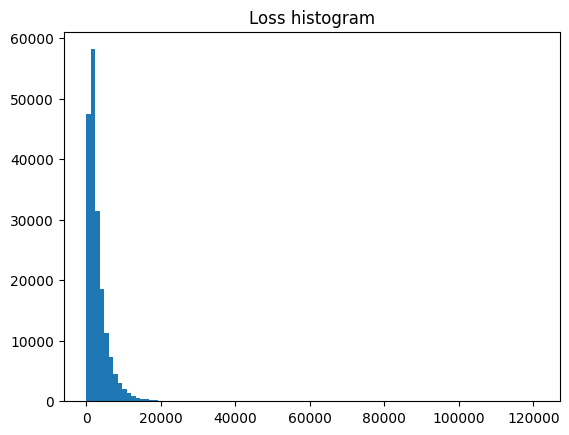

In [7]:
# Plot loss
plt.hist(train['loss'], bins=100)
plt.title('Loss histogram')
plt.show()

We can see that the loss is heavily skewed, thus we may want to transform it for more reliable regression.

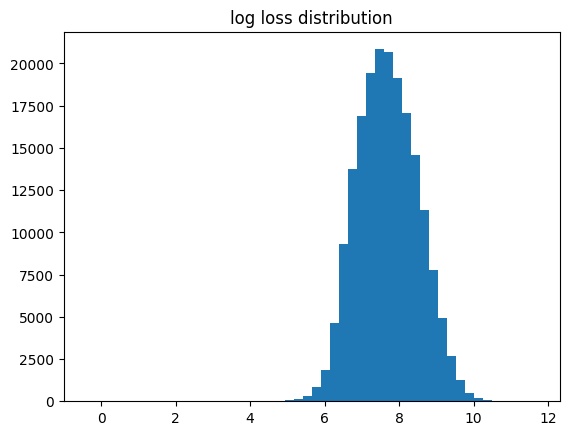

In [8]:
# Transform loss and add to the dataframe
train = pd.concat([train, pd.Series(np.log(train['loss']), name='log_loss').to_frame()], axis=1)    # Use concat for better performance
plt.hist(train['log_loss'], bins=50)
plt.title('log loss distribution')
plt.show()

We notice that the distribution is not located at the center and has a negative left boundary, which means there are one or few values that may be outliers, we want to remove them.

In [9]:
# Remove outliers
outlier_id = train[train['log_loss'] < 0].index
print(f'Log_loss outlier id : {outlier_id}')
print('Train set size before removing outliers: ', n_observations)
train = train.drop(outlier_id)
n_observations = len(train)
print('Train set size after removing outliers: ', n_observations)

Train set size before removing outliers:  188318
Log_loss outlier id : Index([144838], dtype='int64')
Train set size after removing outliers:  188317


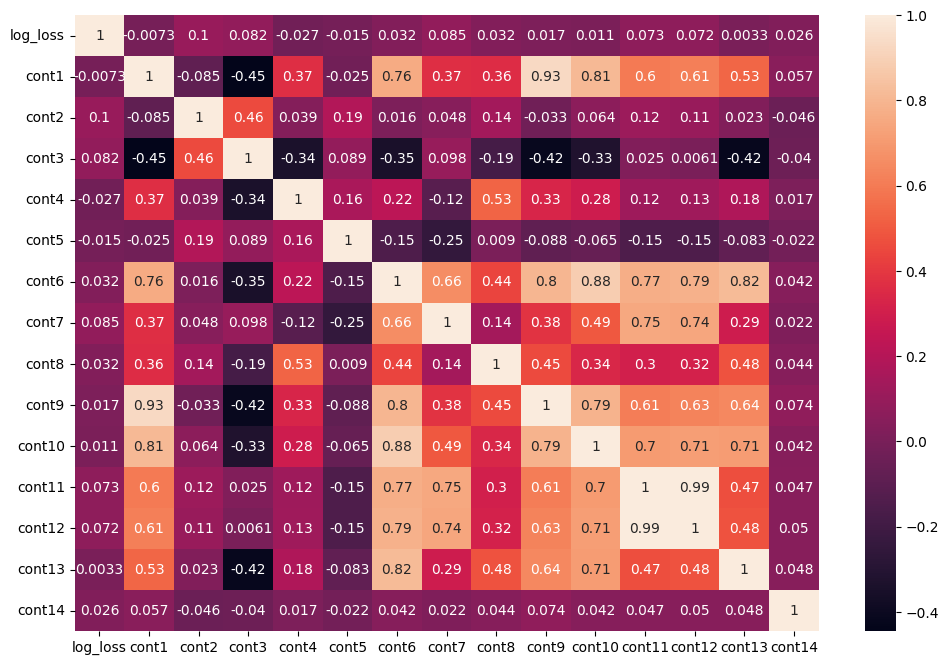

In [10]:
# Examine correlations between continuous features and correlation between features and the loss

# Correlation matrix between continous features and loss
cont_corr = train[['log_loss'] + cont_vars].corr()

# Create heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(12,8))
sb.heatmap(cont_corr, annot=True)
plt.show()

## Feature engineering

In [37]:
# Frequency encoding
def add_feature_cat_count(df_train, df_test, drop_raw=True):
    ''' 
    Add category frequency as a feature to the dataframe. Set 'drop_raw=False' to keep the original categoricals
    '''
    new_cols_train = []
    new_cols_test = []
    
    for var in cat_vars:
        count = df_train[var].value_counts()
        new_col_train = df_train[var].map(count)
        new_col_test = df_test[var].map(count)
        new_col_train.name = f'{var}_count'
        new_col_test.name = f'{var}_count'
        new_cols_train.append(new_col_train.to_frame())
        new_cols_test.append(new_col_test.to_frame())

    if drop_raw:
        return pd.concat([df_train.drop(cat_vars, axis=1)] + new_cols_train, axis=1), pd.concat([df_test.drop(cat_vars, axis=1)] + new_cols_test, axis=1)
    else:
        return pd.concat([df_train] + new_cols_train, axis=1), pd.concat([df_test] + new_cols_test, axis=1)


# Statistical features of continuous variables
def add_feature_cont_stats(df):
    '''
    Add statitics of continuous features (mean, median, std, etc) as features.
    '''
    new_cols = []
    n = len(df)
    df_cont = df[cont_vars]

    cont_sum = df_cont.sum(axis=1).to_frame('cont_sum')
    cont_mean = df_cont.mean(axis=1).to_frame('cont_mean')
    cont_std = df_cont.std(axis=1).to_frame('cont_std')
    cont_med = df_cont.std(axis=1).to_frame('cont_med')
    cont_max = df_cont.max(axis=1).to_frame('cont_max')
    cont_min = df_cont.min(axis=1).to_frame('cont_min')

    new_cols += [cont_sum, cont_mean, cont_med, cont_max, cont_min]

    return pd.concat([df] + new_cols, axis=1)


In [39]:
# Add additional features

train_final = train.copy()
test_final = test.drop('id', axis=1)

# Add fequency encoding features
train_final, test_final = add_feature_cat_count(train_final, test_final)

# Add statistical features
train_final = add_feature_cont_stats(train_final)
test_final = add_feature_cont_stats(test_final)

In [40]:
train_final

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cat112_count,cat113_count,cat114_count,cat115_count,cat116_count,cont_sum,cont_mean,cont_med,cont_max,cont_min
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,...,17669,7033,131693,26813,3194,7.823708,0.558836,0.232770,0.835100,0.187583
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,...,7122,26191,131693,26813,9202,7.047609,0.503401,0.174014,0.885834,0.304496
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,...,2257,6079,131693,7090,2632,4.926918,0.351923,0.142942,0.774425,0.195709
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,...,8453,22030,131693,26813,20244,5.974638,0.426760,0.107094,0.605077,0.317960
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,...,1351,26191,131693,43866,10162,4.328603,0.309186,0.161294,0.704268,0.159990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0.347403,0.785784,0.613660,0.473202,0.939556,0.242437,0.289949,0.24564,0.30859,0.32935,...,3168,26191,131693,16125,10162,5.560120,0.397151,0.227473,0.939556,0.208216
188314,0.507661,0.555782,0.549770,0.802892,0.704268,0.334270,0.382000,0.63475,0.40455,0.47779,...,7122,1630,16474,23895,2519,6.587800,0.470557,0.162421,0.802892,0.301921
188315,0.484469,0.785784,0.792378,0.189137,0.482436,0.345883,0.370534,0.24564,0.45808,0.47779,...,461,6079,131693,43866,20244,6.364251,0.454589,0.169832,0.792378,0.189137
188316,0.438385,0.422197,0.298977,0.383428,0.340543,0.704364,0.562866,0.34987,0.44767,0.53881,...,17669,4425,131693,26813,1960,7.579487,0.541392,0.189577,0.863052,0.298977


## Train/Validation data split

Since we have a large training dataset, we can split it into a training set and a validation set for model evaluation and tuning hyperparameters.

In [41]:
# Split into train/valid
valid_ratio = 0.2
print('Validation ratio : ', valid_ratio)

n_train = int(n_observations * (1-valid_ratio))
n_valid = n_observations - n_train

rng = np.random.default_rng(123)   # For reproducible results
valid_split = train_final.sample(n = n_valid, random_state=rng)
train_split = train_final.drop(valid_split.index)
print('Size of training set   : ', len(train_split))
print('Size of validation set : ', len(valid_split))

X_train = train_split.drop(['loss','log_loss'], axis=1)
Y_train = train_split['log_loss']
X_val = valid_split.drop(['loss','log_loss'], axis=1)
Y_val = valid_split['log_loss']

Validation ratio :  0.2
Size of training set   :  150653
Size of validation set :  37664


## Model building

### Initial model

In [104]:
# Load dataset
lgbm_train = lgbm.Dataset(X_train, label=Y_train)
lgbm_val = lgbm.Dataset(X_val, label=Y_val, reference=lgbm_train)

# lightboost hyperparameters
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'max_depth': 10
}
n_round = 1000
n_stop_round = 10

evals_result = {}

# Train model
start_time = datetime.now()
model = lgbm.train(lgbm_params, lgbm_train, n_round, 
                   valid_sets=[lgbm_train, lgbm_val], valid_names=['train','valid'],
                   callbacks=[lgbm.early_stopping(stopping_rounds=n_stop_round), lgbm.record_evaluation(evals_result)])
end_time = datetime.now()

print('Training time : ', end_time-start_time)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4894
[LightGBM] [Info] Number of data points in the train set: 150653, number of used features: 134
[LightGBM] [Info] Start training from score 7.685778
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.395615	valid's l1: 0.417352
Training time :  0:00:23.978314


### Evaluation

In [44]:
def plot_iteration_loss(eval_res):
    ''' 
    Plot the train and valid loss across training iterations 
    '''
    train_loss = eval_res['train']['l1']
    valid_loss = eval_res['valid']['l1']
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(train_loss, label='train')
    ax.plot(valid_loss, label='valid')
    ax.set_xlabel('iterations')
    ax.set_ylabel('log loss (MAE)')
    ax.legend()
    plt.show()


def evaluate_prediction(log_predict, log_actual):
    '''
    Evaluate the predicted loss (exponentiated log_loss) using Mean Absolute Error (MAE)
    '''
    predict = np.exp(log_predict)
    actual = np.exp(log_actual)
    mae = abs(actual - predict).mean()
    return mae


#def plot_residuals

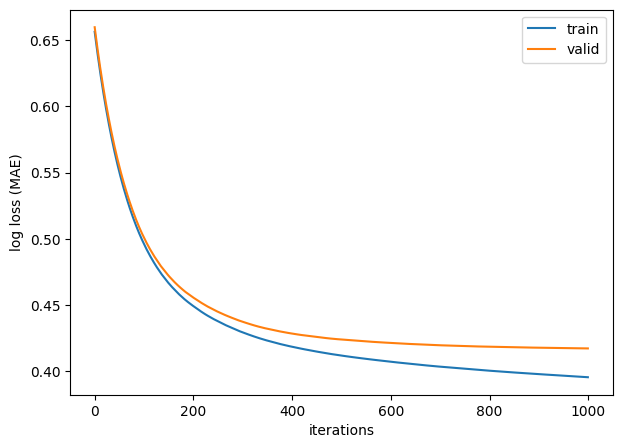

In [105]:
# Plot iteration loss
plot_iteration_loss(evals_result)

In [106]:
# Calculate the MAE on actual loss within the validation set
MAE = evaluate_prediction(model.predict(X_val), Y_val)
print(f'MAE : {MAE:.4f}')

MAE : 1144.0878


In [71]:
# Feature importance
for i, importance in enumerate(model.feature_importance()):
    print(f'{X_train.columns[i]} : {importance}')

cont1 : 4900
cont2 : 6314
cont3 : 4722
cont4 : 4862
cont5 : 4662
cont6 : 4246
cont7 : 9201
cont8 : 5493
cont9 : 3579
cont10 : 3271
cont11 : 3918
cont12 : 3151
cont13 : 4947
cont14 : 15476
cat1_count : 1725
cat2_count : 1999
cat3_count : 700
cat4_count : 1512
cat5_count : 1599
cat6_count : 1425
cat7_count : 301
cat8_count : 610
cat9_count : 923
cat10_count : 318
cat11_count : 428
cat12_count : 715
cat13_count : 457
cat14_count : 109
cat15_count : 0
cat16_count : 267
cat17_count : 207
cat18_count : 174
cat19_count : 371
cat20_count : 6
cat21_count : 212
cat22_count : 90
cat23_count : 705
cat24_count : 248
cat25_count : 619
cat26_count : 807
cat27_count : 1145
cat28_count : 389
cat29_count : 363
cat30_count : 266
cat31_count : 535
cat32_count : 251
cat33_count : 50
cat34_count : 73
cat35_count : 20
cat36_count : 881
cat37_count : 990
cat38_count : 794
cat39_count : 483
cat40_count : 345
cat41_count : 284
cat42_count : 205
cat43_count : 271
cat44_count : 887
cat45_count : 245
cat46_count :

### Hyperparameter tuning

In [ ]:
'''
# valid MAE = 1142.5521
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'max_depth': 10
}
n_round = 1000
n_stop_round = 10


# valid MAE = 1141.2795
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'max_depth': 10
}
n_round = 4000
n_stop_round = 10


# valid MAE = 1141.2795
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'max_depth': 10
}
n_round = 5000
n_stop_round = 10


# valid MAE = 1140.4291
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'max_depth': 10
}
n_round = 5000
n_stop_round = 50


# valid MAE = 1144.7218
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 300,
    'learning_rate': 0.01,
    'max_depth': 10
}
n_round = 4000
n_stop_round = 50
'''

## Final model prediction

In [100]:
# Final model

# Using the whole training set
X_train_final = train_final.drop(['loss','log_loss'], axis=1)
Y_train_final = train_final['log_loss']

lgbm_train_final = lgbm.Dataset(X_train_final, label=Y_train_final)

# Parameters
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'max_depth': 10
}
n_round = 1000
#n_stop_round = 10

# Train model
start_time = datetime.now()
model_final = lgbm.train(lgbm_params, lgbm_train_final, n_round)
end_time = datetime.now()

print('Training time : ', end_time-start_time)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4898
[LightGBM] [Info] Number of data points in the train set: 188317, number of used features: 135
[LightGBM] [Info] Start training from score 7.685311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

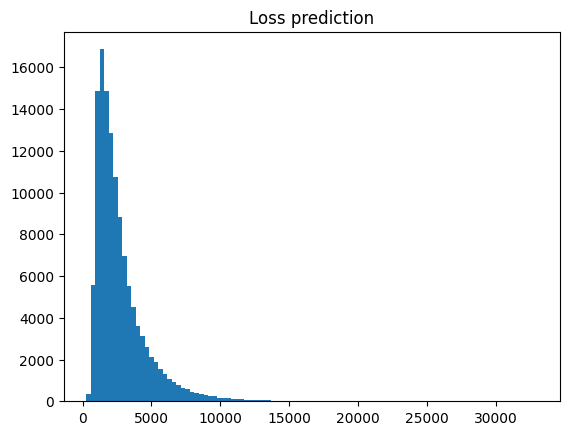

In [101]:
# Get prediction
test_prediction = np.exp(model_final.predict(test_final))    # exponentiate the result since the target of the model is log(loss)

# plot distribution of prediction
plt.hist(test_prediction, bins=100)
plt.title('Loss prediction')
plt.show()

In [102]:
res_df = pd.concat([test['id'], pd.Series(test_prediction, name='loss')], axis=1)
res_df

,id,loss
0,4,1461.467714
1,6,3114.807088
2,9,8666.803506
3,12,5784.123484
4,15,781.406807
...,...,...
125541,587617,2234.628395
125542,587621,2708.527537
125543,587627,3391.200588
125544,587629,1018.942143


In [103]:
res_df.to_csv('result.csv', index=False)   # Scored 1172.90425 with a late submission